In [1]:
import pandas
import datetime
import urllib
import bs4
import numpy
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
def convert_mlon_to_mlt(row):
    currDate = row["date"]
    currMLT = aacgm.mltFromYmdhms(\
                      currDate.year, currDate.month,
                                currDate.day, currDate.hour,
                                currDate.minute, currDate.second,
                                row["BndMlon"]) 
    currMLT = round(currMLT * 10) / 10
    return currMLT

In [3]:
# get dst index vals from wdc kyoto website
# create a list of dates with monthly freq
date_dst_arr = []
dst_val = []
dst_time_del = datetime.timedelta(hours = 1)
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2014,12,31)
daterange = pandas.date_range(start_date, end_date, freq="M")
for dt in daterange:
    if dt.month <= 9:
            monthStr = "0" + str(dt.month)
    else:
        monthStr = str(dt.month)
    if dt.year >= 2015:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_realtime" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    elif ( (dt.year > 2012) and (dt.year < 2015) ):
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_provisional" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    else:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_final" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    conn = urllib.urlopen(currUrl)
    htmlSource = conn.read()
    soup = bs4.BeautifulSoup(htmlSource, 'html.parser')
    dataResObj = soup.find("pre", { "class" : "data" })
    # get the data as a list of strings after removing white space
    lines = dataResObj.text.strip().splitlines()
    for line in lines[6:]:
        columns = line.split()
        if len( columns ) > 0. :
            date_dst_arr.append( datetime.datetime( \
                dt.year, dt.month, int(columns[0]), 1 ) )
            for cols in range( len( columns[1:] ) ) :
                try:
                    inNumberFloatTest = float(columns[cols + 1])
                except:
                    # split these cols as well and work on them!
                    try:
                        missedCols = columns[cols + 1].split("-")[1:]
                        if len(missedCols) >= 1:
                            for mcols in missedCols:
                                dst_val.append( -1*float( mcols ) )
                                # now since we added the date earlier we need to be
                                # careful about appending date values
                                if ( len(date_dst_arr) != len(dst_val) ):
                                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
                    except:
                        print "something wrong with messed up vals!-->", columns[cols + 1]
                        continue
                    continue
                # I have to do this because of the messed up way Kyoto puts up the latest dst value..
                # mixed with 9999 (fillers) like if latest dst is 1 then Kyoto puts it as 199999.....
                if len( columns[ cols + 1 ] ) < 5 :
                    dst_val.append( float( columns[ cols + 1 ] ) )
                elif ( len( columns[ cols + 1 ] ) > 5 and columns[ cols + 1 ][0:3] != '999' ) :
                    mixed_messed_dst = ''
                    for jj in range(5) :
                        if columns[ cols + 1 ][jj] != '9' :
                            mixed_messed_dst = mixed_messed_dst + columns[ cols + 1 ][jj]

                    if mixed_messed_dst != '-' :
                        dst_val.append( float( mixed_messed_dst ) )
                    else :
                        dst_val.append( float( 'nan' ) )
                else :
                    dst_val.append( float( 'nan' ) )
                if cols > 0 :
                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
# convert dst data to a dataframe
dstDF = pandas.DataFrame(
    {'dst_date': date_dst_arr,
     'dst_index': dst_val
    })
dstDF["dateStr"] = dstDF["dst_date"].map(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].map(lambda x: x.strftime('%H'))
dstDF.head()

,dst_date,dst_index,dateStr,hour
0,2011-01-01 01:00:00,-11.0,20110101,01
1,2011-01-01 02:00:00,-11.0,20110101,02
2,2011-01-01 03:00:00,-9.0,20110101,03
3,2011-01-01 04:00:00,-5.0,20110101,04
4,2011-01-01 05:00:00,-3.0,20110101,05


In [4]:
fltdTrghLocFname = "../data/finTrghLocFltrd.txt"
fltTecDataDF = pandas.read_csv(fltdTrghLocFname, sep=' ',\
                            parse_dates=["date"],\
                               infer_datetime_format=True)
# add the dateStr and hour columns to join with Dst DF
fltTecDataDF["dateStr"] = fltTecDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
fltTecDataDF["hour"] = fltTecDataDF["date"].map(lambda x: x.strftime('%H'))
# Merge with Dst DF 
fltTecDataDF = pandas.merge( fltTecDataDF, dstDF, on=["dateStr", "hour"] )
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
fltTecDataDF = pandas.concat( [ fltTecDataDF, \
                    pandas.cut( fltTecDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
fltTecDataDF.columns = [ 'BndEquMlat', 'BndEquTecVal', 'BndMlon', 'BndPolMlat',
                       'BndPolTecVal', 'date', 'minFltrdTecVal', 'minTecMlat',
                       'minTecVal', 'dateStr', 'hour', 'dst_date',
                       'dst_index', 'dst_bin' ]
# GET MLT from MLON
fltTecDataDF["BndMLT"] = fltTecDataDF.apply( convert_mlon_to_mlt, axis=1 )
# GET NORMMLT
fltTecDataDF['BndNormMLT'] = [x-24 if x >= 12 else x for x in fltTecDataDF['BndMLT']]
# Round to nearest half
# fltTecDataDF['BndNormMLTRnd'] = [ round(x * 4) / 4 for x in fltTecDataDF['BndNormMLT'] ]
fltTecDataDF.head()

,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minFltrdTecVal,minTecMlat,minTecVal,dateStr,hour,dst_date,dst_index,dst_bin,BndMLT,BndNormMLT
0,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:00:00,3.842307,59.0,3.5,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8
1,54.0,8.1,2.0,64.0,4.4,2011-04-03 04:00:00,3.577432,60.0,3.6,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.3,-0.7
2,52.0,9.4,4.0,64.0,3.3,2011-04-03 04:00:00,3.461533,60.0,3.6,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.4,-0.6
3,51.0,9.0,6.0,65.0,6.7,2011-04-03 04:00:00,3.465488,60.0,3.8,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.6,-0.4
4,51.0,7.8,8.0,65.0,6.7,2011-04-03 04:00:00,3.501541,59.0,3.3,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.7,-0.3


In [5]:
# Apply some filters to weed out some bad data/events
# 1) data size by MLT and dst_bin
sizeMLTDstDF = fltTecDataDF.groupby( [ "BndNormMLT", "dst_bin" ] ).size().reset_index()
sizeMLTDstDF.columns = [ "BndNormMLT", "dst_bin", "size" ]
# Now we'll calculate percentage of data at each MLT
# We calculate the percentages by grouping data by dst_bins
# similar to our PSAPS calculation
maxSizeDst = sizeMLTDstDF.groupby( "dst_bin" ).max().reset_index()
maxSizeDst = maxSizeDst[ ["dst_bin", "size"] ]
maxSizeDst.columns = [ "dst_bin", "max_size" ]
# Join the maxsize with countDF to get %
sizeMLTDstDF = pandas.merge( sizeMLTDstDF, maxSizeDst, on="dst_bin" )
sizeMLTDstDF["perc_occ"] = sizeMLTDstDF["size"]/sizeMLTDstDF["max_size"]
# Select only those data points which have more than 20% prob of occ
sizeMLTDstDF = sizeMLTDstDF[ \
                    sizeMLTDstDF["perc_occ"] >= 0.2\
                    ].reset_index(drop=True)
# Now limit fltTecDataDF to only those dst_bin, MLT combinations
fltTecDataDF = pandas.merge( fltTecDataDF, sizeMLTDstDF,\
                            on=["BndNormMLT", "dst_bin"], how="inner" )
fltTecDataDF.head()
# cntMLTDstDF.plot(x="BndNormMLT",y="size")

,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minFltrdTecVal,minTecMlat,minTecVal,dateStr,hour,dst_date,dst_index,dst_bin,BndMLT,BndNormMLT,size,max_size,perc_occ
0,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:00:00,3.842307,59.0,3.5,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8,955,1044,0.914751
1,54.0,8.6,0.0,66.0,8.5,2011-04-03 04:05:00,3.842307,59.0,3.5,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8,955,1044,0.914751
2,54.0,6.9,354.0,64.0,6.2,2011-04-03 04:25:00,4.160481,60.0,3.7,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8,955,1044,0.914751
3,55.0,6.7,352.0,64.0,6.1,2011-04-03 04:35:00,3.571449,60.0,2.9,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8,955,1044,0.914751
4,55.0,6.9,350.0,64.0,5.9,2011-04-03 04:45:00,3.244549,60.0,2.3,20110403,04,2011-04-03 04:00:00,-35.0,"(-50, -25]",23.2,-0.8,955,1044,0.914751


In [6]:
# Get MEAN and STD of diff quantities
trghStatDF = fltTecDataDF.groupby( [ "BndNormMLT", "dst_bin" ] ).mean().reset_index()
trghStdDF = fltTecDataDF.groupby( [ "BndNormMLT", "dst_bin" ] ).std().reset_index() 
# Need to replace col names of std df to avoid conf
newColList = []
for col in trghStdDF.columns:
    if ( (col == "BndNormMLT") | (col == "dst_bin") ):
        newCol = col
    else:
        newCol = "std_" + col
    newColList.append( newCol )
trghStdDF.columns = newColList
trghStatDF = pandas.merge( trghStatDF, \
                          trghStdDF,\
                          on=[ "BndNormMLT", "dst_bin" ] )
trghStatDF.dropna(inplace=True)
trghStatDF.head()

,BndNormMLT,dst_bin,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,minFltrdTecVal,minTecMlat,minTecVal,...,std_BndPolMlat,std_BndPolTecVal,std_minFltrdTecVal,std_minTecMlat,std_minTecVal,std_dst_index,std_BndMLT,std_size,std_max_size,std_perc_occ
0,-7.9,"(-150, -75]",56.108696,15.741304,279.913043,66.282609,8.406522,7.259689,63.239130,6.667391,...,2.535640,3.125409,2.545928,2.442083,2.638102,12.328515,0.0,0.0,0.0,0.0
1,-7.8,"(-150, -75]",56.408163,16.320408,283.061224,66.693878,8.310204,7.451428,63.326531,6.961224,...,2.043323,2.877806,2.690479,2.357504,2.717522,13.099988,0.0,0.0,0.0,0.0
2,-7.7,"(-150, -75]",56.931034,14.310345,282.482759,66.620690,8.010345,7.044682,63.293103,6.553448,...,2.262025,2.605776,2.545511,2.294223,2.580984,12.756598,0.0,0.0,0.0,0.0
3,-7.6,"(-150, -75]",56.730159,14.400000,283.904762,66.333333,7.969841,6.915618,62.888889,6.401587,...,2.608918,3.006532,2.600358,2.410402,2.611111,11.642019,0.0,0.0,0.0,0.0
4,-7.6,"(-75, -50]",57.500000,12.093939,275.696970,67.136364,7.033333,5.962966,63.712121,5.395455,...,2.733757,1.604545,1.513992,3.238068,1.572204,6.781797,0.0,0.0,0.0,0.0


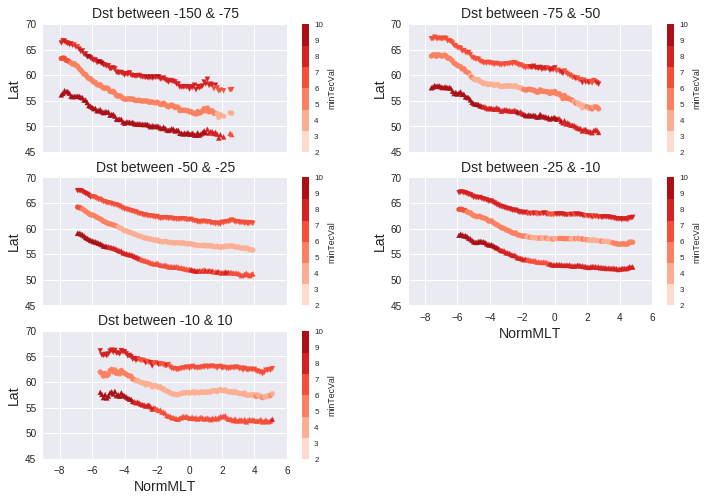

In [7]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)


sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
trghMLTLat15075 = trghStatDF[ trghStatDF["dst_bin"] == "(-150, -75]" ]
trghMLTLat15075.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax1, vmin=2., vmax=10., sharex=True)
trghMLTLat15075.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax1, vmin=2., vmax=10., colorbar=False)
trghMLTLat15075.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax1, vmin=2., vmax=10., colorbar=False)
ax1.set_ylabel("Lat", fontsize=14)
ax1.set_xlabel("NormMLT", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
ax1.set_xlim( [-9,6] )
ax1.set_ylim( [45,70] )
# (-75, -50]
trghMLTLat7550 = trghStatDF[ trghStatDF["dst_bin"] == "(-75, -50]" ]
trghMLTLat7550.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax2, vmin=2., vmax=10.)
trghMLTLat7550.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax2, vmin=2., vmax=10., colorbar=False)
trghMLTLat7550.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax2, vmin=2., vmax=10., colorbar=False)
ax2.set_ylabel("Lat", fontsize=14)
ax2.set_xlabel("NormMLT", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
ax2.set_xlim( [-9,6] )
ax2.set_ylim( [45,70] )
# (-50, -25]
trghMLTLat5025 = trghStatDF[ trghStatDF["dst_bin"] == "(-50, -25]" ]
trghMLTLat5025.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax3, vmin=2., vmax=10.)
trghMLTLat5025.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax3, vmin=2., vmax=10., colorbar=False)
trghMLTLat5025.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax3, vmin=2., vmax=10., colorbar=False)
ax3.set_ylabel("Lat", fontsize=14)
ax3.set_xlabel("NormMLT", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
ax3.set_xlim( [-9,6] )
ax3.set_ylim( [45,70] )
# (-25, -10]
trghMLTLat2510 = trghStatDF[ trghStatDF["dst_bin"] == "(-25, -10]" ]
trghMLTLat2510.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax4, vmin=2., vmax=10.)
trghMLTLat2510.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax4, vmin=2., vmax=10., colorbar=False)
trghMLTLat2510.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax4, vmin=2., vmax=10., colorbar=False)
ax4.set_ylabel("Lat", fontsize=14)
ax4.set_xlabel("NormMLT", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
ax4.set_xlim( [-9,6] )
ax4.set_ylim( [45,70] )
# (-10, 10]
trghMLTLat1010 = trghStatDF[ trghStatDF["dst_bin"] == "(-10, 10]" ]
trghMLTLat1010.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax5, vmin=2., vmax=10.)
trghMLTLat1010.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax5, vmin=2., vmax=10., colorbar=False)
trghMLTLat1010.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax5, vmin=2., vmax=10., colorbar=False)

ax5.set_ylabel("Lat", fontsize=14)
ax5.set_xlabel("NormMLT", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
ax5.set_xlim( [-9,6] )
ax5.set_ylim( [45,70] )
plt.savefig("../fin-figs/allBinsTrghBnds.pdf",bbox_inches='tight')

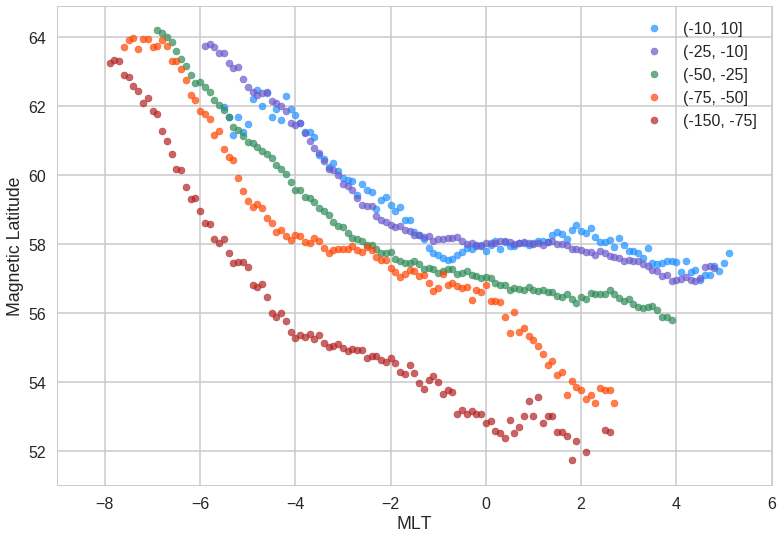

In [8]:
sns.set_style("whitegrid")
sns.set_context("poster")


###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
# trghStatDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-10, 10]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 50,
            label='(-10, 10]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-10, 10]"],\
#              trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-10, 10]"],\
#              yerr=trghStatDF['std_minTecMlat'][trghStatDF['dst_bin'] == "(-10, 10]"], \
#              color='dodgerblue', label='', capthick=2., capsize=5.)

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
# trghStatDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-25, -10]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 50,
            label='(-25, -10]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-25, -10]"],\
#              trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-25, -10]"],\
#              yerr=trghStatDF['std_minTecMlat'][trghStatDF['dst_bin'] == "(-25, -10]"], \
#              color='slateblue', label='', capthick=2., capsize=5.)
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######



###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-50, -25]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 50,
            label='(-50, -25]')

# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-50, -25]"],\
#              trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-50, -25]"],\
#              yerr=trghStatDF['std_minTecMlat'][trghStatDF['dst_bin'] == "(-50, -25]"],\
#              color='seagreen', label='', capthick=2., capsize=5.)

###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######



# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-75, -50]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 50,
            label='(-75, -50]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-75, -50]"],\
#              trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-75, -50]"],\
#              yerr=trghStatDF['std_minTecMlat'][trghStatDF['dst_bin'] == "(-75, -50]"],\
#              color='orangered', label='', capthick=2., capsize=5.)

###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######



# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-150, -75]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 50,
            label='(-150, -75]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-150, -75]"],\
#              trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-150, -75]"],\
#              yerr=trghStatDF['std_minTecMlat'][trghStatDF['dst_bin'] == "(-150, -75]"], \
#              color='firebrick', label='', capthick=2., capsize=5.)

# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-9,6] )
plt.xlabel("MLT")
plt.ylabel("Magnetic Latitude")
plt.legend()
plt.savefig("../fin-figs/meanStdMinTrghLoc.pdf",bbox_inches='tight')

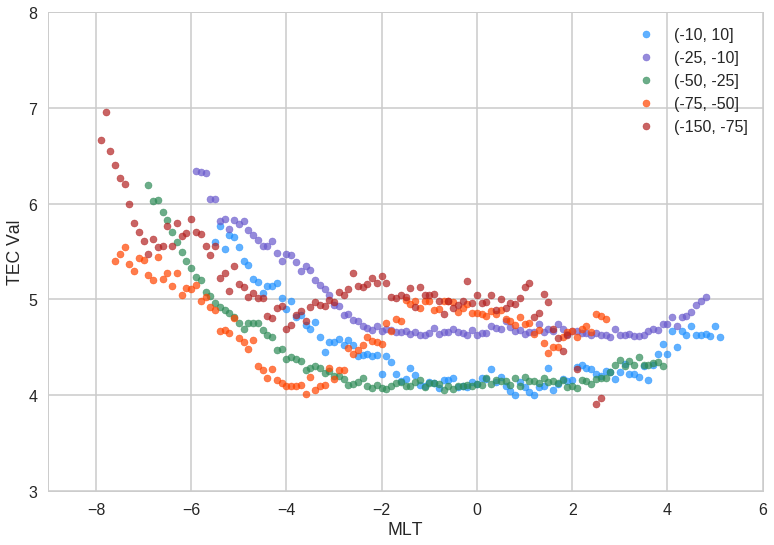

In [9]:
sns.set_style("whitegrid")
sns.set_context("poster")


###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
# trghStatDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-10, 10]"],
            trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 50,
            label='(-10, 10]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-10, 10]"],\
#              trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-10, 10]"],\
#              yerr=trghStatDF['std_minTecVal'][trghStatDF['dst_bin'] == "(-10, 10]"], \
#              color='dodgerblue', label='', capthick=2., capsize=5.)

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
# trghStatDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-25, -10]"],
            trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 50,
            label='(-25, -10]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-25, -10]"],\
#              trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-25, -10]"],\
#              yerr=trghStatDF['std_minTecVal'][trghStatDF['dst_bin'] == "(-25, -10]"], \
#              color='slateblue', label='', capthick=2., capsize=5.)
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######



###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-50, -25]"],
            trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 50,
            label='(-50, -25]')

# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-50, -25]"],\
#              trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-50, -25]"],\
#              yerr=trghStatDF['std_minTecVal'][trghStatDF['dst_bin'] == "(-50, -25]"],\
#              color='seagreen', label='', capthick=2., capsize=5.)

###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######



# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-75, -50]"],
            trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 50,
            label='(-75, -50]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-75, -50]"],\
#              trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-75, -50]"],\
#              yerr=trghStatDF['std_minTecVal'][trghStatDF['dst_bin'] == "(-75, -50]"],\
#              color='orangered', label='', capthick=2., capsize=5.)

###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######



# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-150, -75]"],
            trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 50,
            label='(-150, -75]')
# plt.errorbar(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-150, -75]"],\
#              trghStatDF['minTecVal'][trghStatDF['dst_bin'] == "(-150, -75]"],\
#              yerr=trghStatDF['std_minTecVal'][trghStatDF['dst_bin'] == "(-150, -75]"], \
#              color='firebrick', label='', capthick=2., capsize=5.)

# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-9,6] )
plt.ylim( [3,8] )
plt.xlabel("MLT")
plt.ylabel("TEC Val")
plt.legend()
plt.savefig("../fin-figs/meanStdMinTrghVal.pdf",bbox_inches='tight')

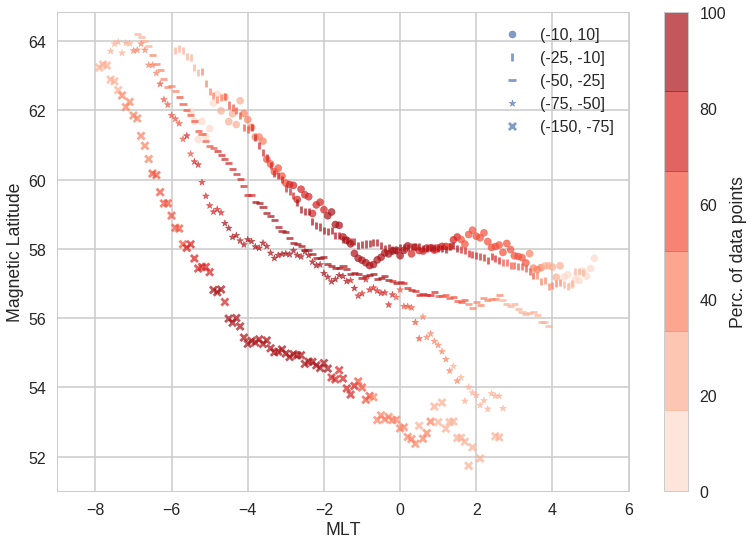

In [10]:
sns.set_style("whitegrid")
sns.set_context("poster")

seaMap = ListedColormap(sns.color_palette("Reds"))

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
# trghStatDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-10, 10]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            c=trghStatDF['perc_occ'][trghStatDF['dst_bin'] == "(-10, 10]"]*100,
            cmap=seaMap,
            alpha=0.7,
            s = 50,
            label='(-10, 10]')


###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-25, -10]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-25, -10]"],
            marker='|',
            c=trghStatDF['perc_occ'][trghStatDF['dst_bin'] == "(-25, -10]"]*100,
            cmap=seaMap,
            alpha=0.7,
            s = 50, vmin=0, vmax=100,
            label='(-25, -10]')

# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-50, -25]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-50, -25]"],
            marker="_",
            c=trghStatDF['perc_occ'][trghStatDF['dst_bin'] == "(-50, -25]"]*100,
            cmap=seaMap,
            alpha=0.7,
            s = 50, vmin=0, vmax=100,
            label='(-50, -25]')



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######



# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-75, -50]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-75, -50]"],
            marker='*',
            c=trghStatDF['perc_occ'][trghStatDF['dst_bin'] == "(-75, -50]"]*100,
            cmap=seaMap,
            alpha=0.7,
            s = 50, vmin=0, vmax=100,
            label='(-75, -50]')


# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######



# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(trghStatDF['BndNormMLT'][trghStatDF['dst_bin'] == "(-150, -75]"],
            trghStatDF['minTecMlat'][trghStatDF['dst_bin'] == "(-150, -75]"],
            marker='x',
            c=trghStatDF['perc_occ'][trghStatDF['dst_bin'] == "(-150, -75]"]*100,
            cmap=seaMap,
            alpha=0.7,
            s = 50, vmin=0, vmax=100,
            label='(-150, -75]')


# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-9,6] )
plt.xlabel("MLT")
plt.ylabel("Magnetic Latitude")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Perc. of data points')
plt.legend()
plt.savefig("../fin-figs/trghPercOcc.pdf",bbox_inches='tight')

In [11]:
# Here we'll compare SAPS mean location with TEC Boundaries and Min loc!!!
sapsProbFileName = "../data/sapsProbs.txt"
sapsProbDF = pandas.read_csv(sapsProbFileName, sep=' ')
# Discard rows where prob of occ is less than 0.2
sapsProbDF = sapsProbDF[ sapsProbDF["probOcc"] >= 0.15 ].reset_index(drop=True)
sapsProbDF.head()

,dst_bin,sapsMLT,sapsLat,normMLT,normLAT,dataCount,maxCount,MLT,probOcc
0,"(-150, -75]",0.0,55.5,0.0,-2.0,50,333,0,0.150150
1,"(-150, -75]",1.0,54.5,1.0,-3.0,74,333,1,0.222222
2,"(-150, -75]",1.0,55.5,1.0,-2.0,80,333,1,0.240240
3,"(-150, -75]",1.0,56.5,1.0,-1.0,82,333,1,0.246246
4,"(-150, -75]",1.0,57.5,1.0,0.0,50,333,1,0.150150


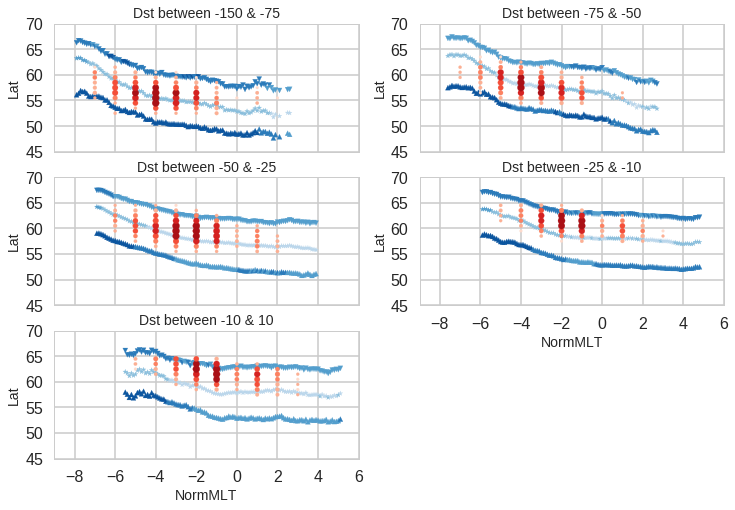

In [12]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)


sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Blues"))
sapsSeaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
trghMLTLat15075 = trghStatDF[ trghStatDF["dst_bin"] == "(-150, -75]" ]
trghMLTLat15075.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal', marker='*',
              s=25, cmap=seaMap, ax=ax1, vmin=2., vmax=10., sharex=True, colorbar=False)
trghMLTLat15075.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax1, vmin=2., vmax=10., colorbar=False)
trghMLTLat15075.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax1, vmin=2., vmax=10., colorbar=False)
sapsProbDF15075 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-150, -75]" ]
sapsProbDF15075.plot( kind='scatter',
              x='normMLT',
              y='sapsLat',
              c='probOcc',
              s=sapsProbDF15075["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax1, colorbar=False)

ax1.set_ylabel("Lat", fontsize=14)
ax1.set_xlabel("NormMLT", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
ax1.set_xlim( [-9,6] )
ax1.set_ylim( [45,70] )

# (-75, -50]
trghMLTLat7550 = trghStatDF[ trghStatDF["dst_bin"] == "(-75, -50]" ]
trghMLTLat7550.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',marker='*',
              s=25, cmap=seaMap, ax=ax2, vmin=2., vmax=10., colorbar=False)
trghMLTLat7550.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax2, vmin=2., vmax=10., colorbar=False)
trghMLTLat7550.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax2, vmin=2., vmax=10., colorbar=False)
sapsProbDF7550 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-75, -50]" ]
sapsProbDF7550.plot( kind='scatter',
              x='normMLT',
              y='sapsLat',
              c='probOcc',
              s=sapsProbDF7550["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax2, colorbar=False)
ax2.set_ylabel("Lat", fontsize=14)
ax2.set_xlabel("NormMLT", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
ax2.set_xlim( [-9,6] )
ax2.set_ylim( [45,70] )
# (-50, -25]
trghMLTLat5025 = trghStatDF[ trghStatDF["dst_bin"] == "(-50, -25]" ]
trghMLTLat5025.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',marker='*',
              s=25, cmap=seaMap, ax=ax3, vmin=2., vmax=10., colorbar=False)
trghMLTLat5025.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax3, vmin=2., vmax=10., colorbar=False)
trghMLTLat5025.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax3, vmin=2., vmax=10., colorbar=False)
sapsProbDF5025 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-50, -25]" ]
sapsProbDF5025.plot( kind='scatter',
              x='normMLT',
              y='sapsLat',
              c='probOcc',
              s=sapsProbDF5025["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax3, colorbar=False)
ax3.set_ylabel("Lat", fontsize=14)
ax3.set_xlabel("NormMLT", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
ax3.set_xlim( [-9,6] )
ax3.set_ylim( [45,70] )
# (-25, -10]
trghMLTLat2510 = trghStatDF[ trghStatDF["dst_bin"] == "(-25, -10]" ]
trghMLTLat2510.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',marker='*',
              s=25, cmap=seaMap, ax=ax4, vmin=2., vmax=10., colorbar=False)
trghMLTLat2510.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax4, vmin=2., vmax=10., colorbar=False)
trghMLTLat2510.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax4, vmin=2., vmax=10., colorbar=False)
sapsProbDF2510 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-25, -10]" ]
sapsProbDF2510.plot( kind='scatter',
              x='normMLT',
              y='sapsLat',
              c='probOcc',
              s=sapsProbDF2510["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax4, colorbar=False)
ax4.set_ylabel("Lat", fontsize=14)
ax4.set_xlabel("NormMLT", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
ax4.set_xlim( [-9,6] )
ax4.set_ylim( [45,70] )
# (-10, 10]
trghMLTLat1010 = trghStatDF[ trghStatDF["dst_bin"] == "(-10, 10]" ]
trghMLTLat1010.plot( kind='scatter',
              x='BndNormMLT',
              y='minTecMlat',
              c='minTecVal',marker='*',
              s=25, cmap=seaMap, ax=ax5, vmin=2., vmax=10., colorbar=False)
trghMLTLat1010.plot( kind='scatter',
              x='BndNormMLT',
              y='BndEquMlat',
              c='BndEquTecVal',
              s=25, cmap=seaMap, marker='^', ax=ax5, vmin=2., vmax=10., colorbar=False)
trghMLTLat1010.plot( kind='scatter',
              x='BndNormMLT',
              y='BndPolMlat',
              c='BndPolTecVal',
              s=25, cmap=seaMap, marker='v', ax=ax5, vmin=2., vmax=10., colorbar=False)
sapsProbDF1010 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-10, 10]" ]
sapsProbDF1010.plot( kind='scatter',
              x='normMLT',
              y='sapsLat',
              c='probOcc',
              s=sapsProbDF1010["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax5, colorbar=False)
ax5.set_ylabel("Lat", fontsize=14)
ax5.set_xlabel("NormMLT", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
ax5.set_xlim( [-9,6] )
ax5.set_ylim( [45,70] )

plt.savefig("../fin-figs/trghBnds-SAPS.pdf",bbox_inches='tight')

In [13]:
# WE'd like to plot the TEC troughs on IDL MLT maps
# like we did for SAPS probs and vels
# Due to difficulty in reading str values in IDL
# WE'll simply use a number (mean dst) for a dst bin
# create a func for the samedef convert_mlon_to_mlt(row):
def convert_dst_bin_to_num(row):
    currDstBin = row["dst_bin"]
    if currDstBin == "(-10, 10]":
        return -5.0
    if currDstBin == "(-25, -10]":
        return -18.0
    if currDstBin == "(-50, -25]":
        return -36.0
    if currDstBin == "(-75, -50]":
        return -57.0
    if currDstBin == "(-150, -75]":
        return -95.0
    
trghStatDF["dst_med"] = trghStatDF.apply( convert_dst_bin_to_num, axis=1 )
# Write to csv file
trghStatDF = trghStatDF.round(2)
trghStatDF.to_csv("../data/trghBnds-idl.txt", sep=' ', index=False,\
                 columns = [ "dst_med", "BndMlon", "BndEquMlat", "BndEquTecVal",\
                           "BndPolMlat", "BndPolTecVal", "minTecMlat",\
                            "minTecVal", "BndMLT", "BndNormMLT"])